# ScanPy Basics

This notebook follows a tutorial on the basic capabilities of the ScanPy library for single cell data analysis. Among the topics covered will be quality control, normalization, feature selection, dimensionality reductions, nearest neighbor graphs and visualization, clustering, and more. The basic data object will be AnnData -- see that tutorial for more details.

In [32]:
import scanpy as sc
import anndata as ad
import pooch  # for data retreival

In [33]:
sc.settings.set_figure_params(dpi=50, facecolor="white")

For this tutorial, we will use a dataset of bone marrow mononuclear cells of healthy human donors from openproblems's NeurIPS 2021 benchmarking dataset: https://openreview.net/forum?id=gN35BGa1Rt

The samples from this tutorial were measured using the 10X Multiome Gene Expression and Chromatin Accessability kit.

Reference: Luecken, Malte D., et al. "A sandbox for prediction and integration of DNA, RNA, and proteins in single cells." Thirty-fifth conference on neural information processing systems datasets and benchmarks track (Round 2). 2021.

In [34]:
# download links
EXAMPLE_DATA = pooch.create(
    path=pooch.os_cache("scverse_tutorials"),
    base_url="doi:10.6084/m9.figshare.22716739.v1/",
)
EXAMPLE_DATA.load_registry_from_doi()

In [35]:
# download and set up data
samples = {
    "s1d1": "s1d1_filtered_feature_bc_matrix.h5",
    "s1d3": "s1d3_filtered_feature_bc_matrix.h5",
}
adatas = {}

for sample_id, filename in samples.items():
    path = EXAMPLE_DATA.fetch(filename)
    sample_adata = sc.read_10x_h5(path)
    sample_adata.var_names_make_unique()
    adatas[sample_id] = sample_adata

adata = ad.concat(adatas, label="sample")
adata.obs_names_make_unique()
print(adata.obs["sample"].value_counts())
adata

c:\Users\natha\Documents\pyro_pytorch_tutorials\pyro_pytorch_venv\Lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\natha\Documents\pyro_pytorch_tutorials\pyro_pytorch_venv\Lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\natha\Documents\pyro_pytorch_tutorials\pyro_pytorch_venv\Lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\natha\Documents\pyro_pytorch_tutorials\pyro_pytorch_venv\Lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


sample
s1d1    8785
s1d3    8340
Name: count, dtype: int64


c:\Users\natha\Documents\pyro_pytorch_tutorials\pyro_pytorch_venv\Lib\site-packages\anndata\_core\anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 17125 × 36601
    obs: 'sample'

### Quality Control

The scanpy function calculate_qc_metrics() calculates some common quality control metrics, such as number of genes expressed in the count matrix, total counts per cells, and percentage of counts in mitochondrial genes.

In [36]:
# label some types of genes
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

In [37]:
# calculate qc metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)

In [38]:
# notice that the above function added several observation-level (cell-level) and var-level (gene-level)
#   QC metrics, such as number of genes expressed in count matrix, total counts per cell, percentage of mitochondrial genes, etc
adata

AnnData object with n_obs × n_vars = 17125 × 36601
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

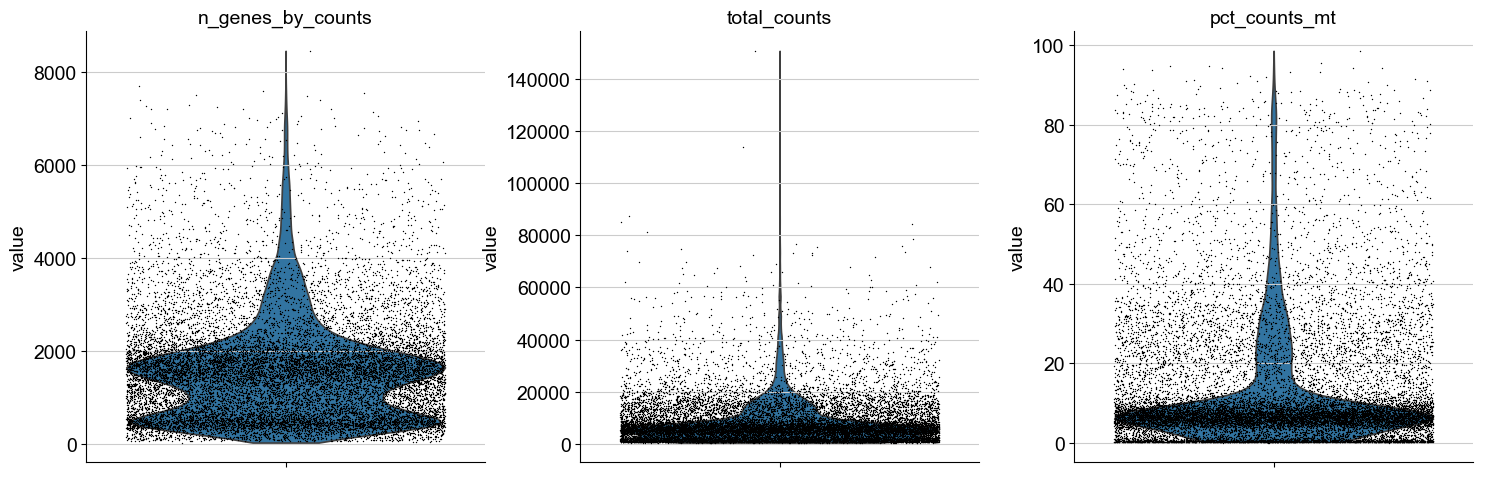

In [39]:
# make a violin plot of the aforementioned QC metrics
sc.pl.violin(adata,
             ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
             jitter=0.4, multi_panel=True,)

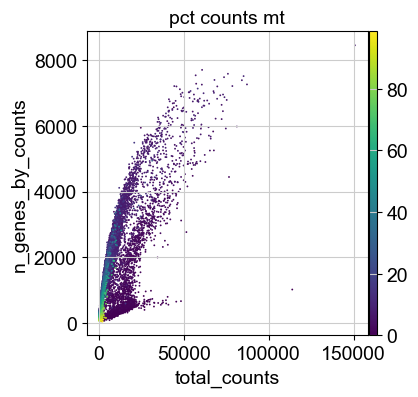

In [40]:
# another useful thing is a scatter plot of gene counts colored by mitochondrial percentage
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

One might now remove cells that have too many mitochondrial genes expressed or too many total counts via manual or automatic threshold. However, what appears to be poor QC can sometimes be real biology, so it often helps to start with a very permissive threshold. Here we will show how to filter cells with fewer than 100 genes expressed and genes that are detected in fewer than 3 cells.

Also, for multi-batch data, QC should be performed for each sample individually since QC thresholds can vary substantially between batches.

In [41]:
# filter cells with very few expressed genes, and genes expressed in very few cells
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

Another important step is doublet detection. Filtering doublets is important because they can lead to misclassifications and distortions in downstream analysis. Scanpy has the Scrublet method (Wolock et al 2019) implemented. scanpy.pp.scrublet() adds "doublet_score" and "predicted doublet" to .obs. One can now filter on either of those, or use them later.

In [42]:
sc.pp.scrublet(adata, batch_key="sample")

Other doublet detection methods implemented in Scanpy include DoubletDetection and SOLO.

### Normalization

After QC, we want to perform normalization to correct for things like different library sizes between datasets. A common approach is count depth scaling with subsequent log plus one (log1p) transformation. Count depth scaling normalizes the data to a "size factor" such as the count depth in the dataset or counts per million (CPM). The size factor for count depth scaling can be controlled via `target_sum` in `pp.normalize_total`. We will apply median count depth normalization with log1p transformation, i.e. "log1PF".

In [43]:
# saving original count data
adata.layers["counts"] = adata.X.copy()

In [44]:
import numpy as np
lay = adata.to_df(layer="counts")
print(np.mean(lay))
print(np.max(lay))
print(np.min(lay))

0.3484324
70422.0
0.0


In [45]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

In [46]:
lay = adata.to_df()
print(np.mean(lay))
print(np.max(lay))
print(np.min(lay))

0.060651172
8.421899
0.0


### Feature Selection

As a next step, we want to reduce the dimensionality of the dataset and include only the most informative genes. This step is commonly called "feature selection". The scanpy function `pp.highly_variable_genes` annotates highly variable genes by reproducing the implementations of Seurat, Cell Ranger, and Seurat v3, depending on the chosen "`flavor`".

In [47]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="sample")

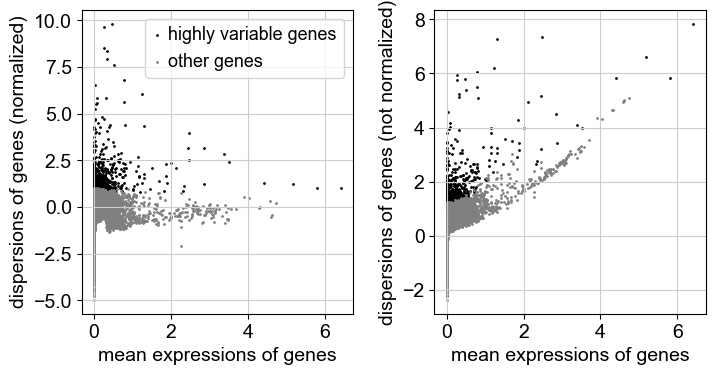

In [48]:
# plot of highly variable vs other genes
sc.pl.highly_variable_genes(adata)

In [49]:
adata  # has the 'highly_variable' var-level metadata now
# also notice that 'hvg' uns (unstructured) variable has been added, indicating the "flavor" (here, Seurat)

AnnData object with n_obs × n_vars = 17041 × 23427
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'scrublet', 'log1p', 'hvg'
    layers: 'counts'

In [50]:
adata.var["highly_variable"][140:150]

CAMTA1-IT1    False
VAMP3         False
Z98884.2      False
PER3           True
Z98884.1      False
UTS2          False
TNFRSF9        True
PARK7         False
AL034417.4     True
AL034417.3    False
Name: highly_variable, dtype: bool

In [51]:
adata.uns["hvg"]

{'flavor': 'seurat'}

### Dimensionality reduction

We can now reduce the dimensionality of the data by running principal component analysis (PCA) to reveal the main axes of variation and denoise the data.

In [52]:
# run pca
sc.tl.pca(adata)

In [53]:
adata  # notice the PCs field added to varm

AnnData object with n_obs × n_vars = 17041 × 23427
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'scrublet', 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [54]:
adata.varm["PCs"]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Let's inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering functions `leiden()` and `tsne()`. In their experience, there does not seem to be significant downside the overestimating the number of principal components.

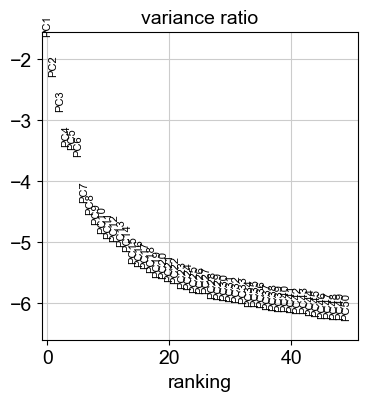

In [55]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

It is also a very good idea to plot PCs to see if they are capturing potentially undesirable features such as batch, QC metrics, etc that may be driving significant variation in the dataset. In this case there doesn't seem to be anything too alarming, but it's good to check.

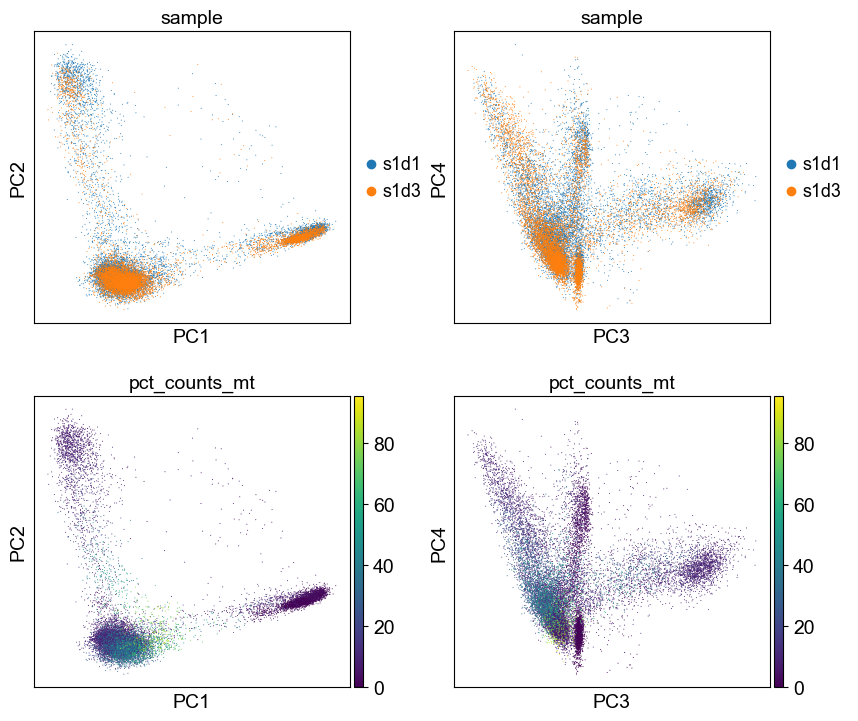

In [56]:
# we'll look at how PCs 1 and 2 (indices 0 and 1) and PCs 3 and 4 are correlated with sample and mitochondrial gene percentage;
#   notice how this is implemented below
sc.pl.pca(
    adata,
    color=["sample", "sample", "pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0,1), (2,3), (0,1), (2,3)],
    ncols=2, size=2,
)

### Nearest neightbor graph construction and visualization

We can use scanpy to compute the nearest neighbor graph of cells using PCA representation of the data matrix. Then we can embed and visualize this graph in two dimensions with UMAP.

In [57]:
# compute nearest neighbor graph
sc.pp.neighbors(adata)

In [58]:
# embed the graph in two dimensions
sc.tl.umap(adata)

In [59]:
adata  # notice the "neighbors" and "umap" metadata added

AnnData object with n_obs × n_vars = 17041 × 23427
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'scrublet', 'log1p', 'hvg', 'pca', 'sample_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

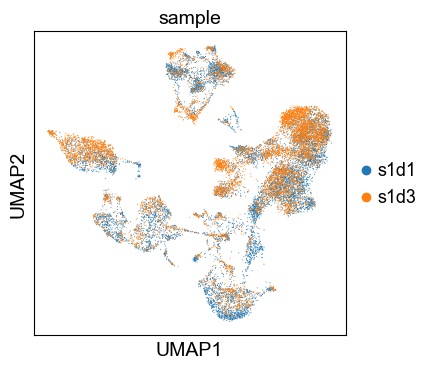

In [60]:
# now visualize with UMAP
sc.pl.umap(adata, color="sample", size=2,)

Here, s1d1 and s1d3 are different batches ("samples") in the dataset. By coloring by sample and plotting, we can see that these samples don't separate too much. That's one indicator that batch effects aren't too bad, so we can continue with clustering and annotation of our data.

It can be helpful to integrate across samples and perform batch correction and integration. This can be done with some methods implemented as part of `scvi-tools` and `scanorama`, for example.

### Clustering

Many frameworks use the Leiden graph clustering method (community detection based on optimizing modularity) -- see Traag et al 2019 -- to cluster cells for annotation. Note that Leiden clustering directly clusters the neighborhood graph of cells, computed from the previous section.

In [63]:
# using the igraph implementation and a fixed number of iterations can be significantly faster for large datasets
# UPDATE: this crashes on Windows machines and is a known issue, i.e. https://github.com/scverse/scanpy/issues/2969
# sc.tl.leiden(adata, flavor="igraph", n_iterations=2)

# for windows, do not do igraph flavor
sc.tl.leiden(adata, n_iterations=2)

C:\Users\natha\AppData\Local\Temp\ipykernel_21948\333731827.py:6: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, n_iterations=2)


Now let's re-assess quality control and cell filtering by visualizing different QC metrics using UMAP, including our Leiden clusters and doublet predictions.

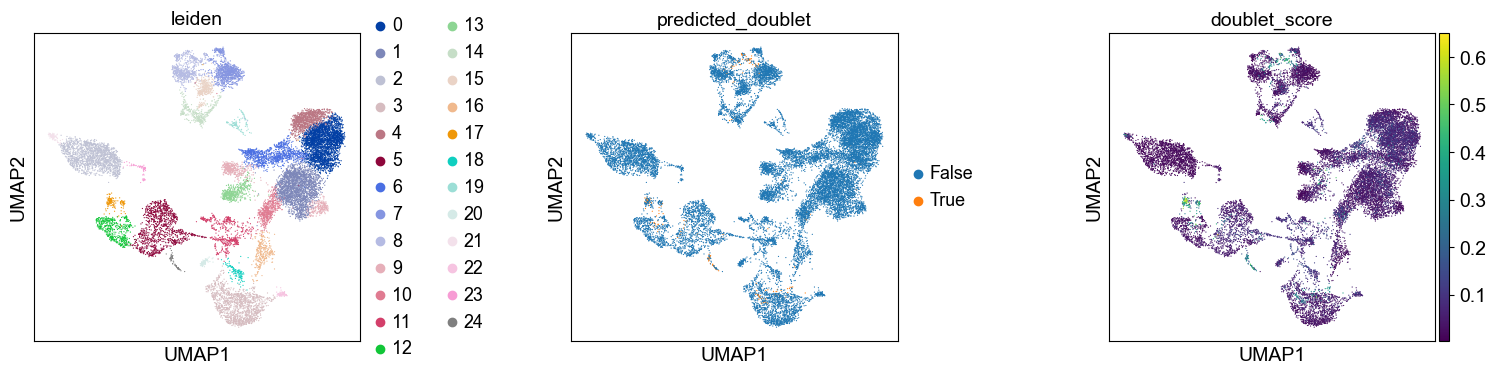

In [64]:
sc.pl.umap(adata,
           color=["leiden", "predicted_doublet", "doublet_score"],
           wspace=0.5, size=3)

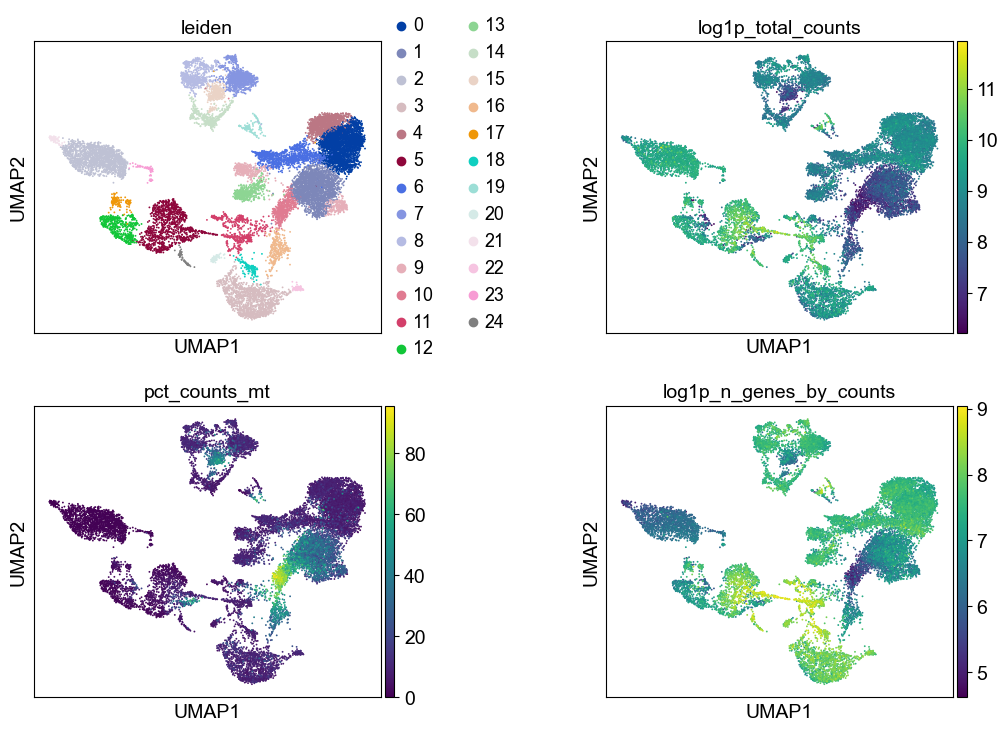

In [67]:
sc.pl.umap(adata, 
           color=["leiden", "log1p_total_counts", "pct_counts_mt", "log1p_n_genes_by_counts"],
           wspace=0.5, ncols=2,)

### Manual cell type annotation

Cell type annotation can be quite laborious and repetitive, but scanpy has some abilities that can help. Now that we've preprocessed our data and it has decent quality, we can proceed to annotation of known cell types. Typically this is done using "marker genes" that are unique to cell types. Some databases of known marker genes include CellMarker, TF-Marker, and PanglaoDB. The [cellxgene gene expression tool](https://cellxgene.cziscience.com/gene-expression) can also be quite useful to see which cell types a gene has been expressed in across many existing domains.

Clasically, clustering is performed prior to annotation using marker genes. So let's start by defining a series of clustering solutions using Leiden clustering.

In [70]:
for res in [0.02, 0.5, 2.0]:
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}", resolution=res
    )

We used several different "resolution" parameters since the number of clusters we define is fairly arbitrary. So let's try to visualize these and see what looks reasonable.

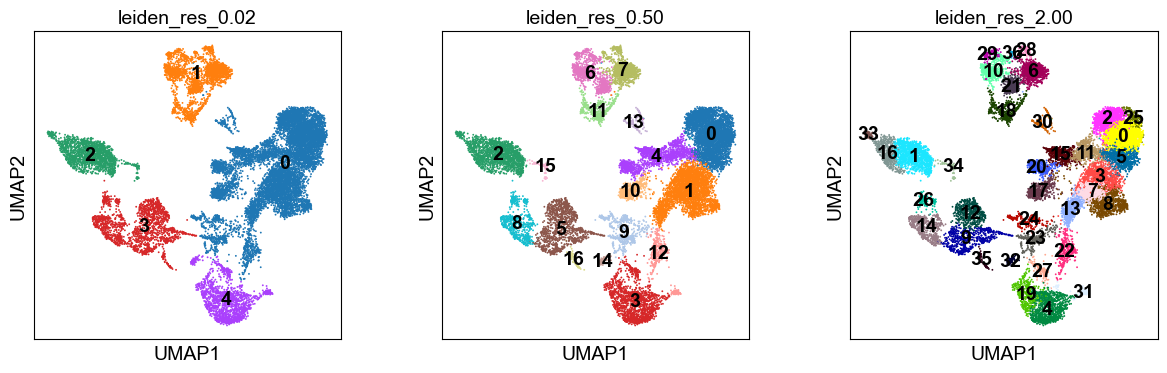

In [71]:
sc.pl.umap(
    adata,
    color=["leiden_res_0.02", "leiden_res_0.50", "leiden_res_2.00"],
    legend_loc="on data",
)

It looks like the highest resolution (2.00) is overclustered, while the lowest resolution (0.02) is underclustered. A resolution of 0.5 thus seems to fit the data best. However, note that this is a qualitative interpretation of the UMAP clustering and shouldn't be over-interpreted.

Now let's define a set of marker genes for the main cell types we expect to see in this dataset. This is adapted from a chapter of the [single cell best practices](https://www.sc-best-practices.org/cellular_structure/annotation.html) book.

In [72]:
marker_genes = {
    "CD14+ Mono": ["FCN1", "CD14"],
    "CD16+ Mono": ["TCF7L2", "FCGR3A", "LYN"],
    # Note: DMXL2 should be negative
    "cDC2": ["CST3", "COTL1", "LYZ", "DMXL2", "CLEC10A", "FCER1A"],
    "Erythroblast": ["MKI67", "HBA1", "HBB"],
    # Note HBM and GYPA are negative markers
    "Proerythroblast": ["CDK6", "SYNGR1", "HBM", "GYPA"],
    "NK": ["GNLY", "NKG7", "CD247", "FCER1G", "TYROBP", "KLRG1", "FCGR3A"],
    "ILC": ["ID2", "PLCG2", "GNLY", "SYNE1"],
    "Naive CD20+ B": ["MS4A1", "IL4R", "IGHD", "FCRL1", "IGHM"],
    # Note IGHD and IGHM are negative markers
    "B cells": [
        "MS4A1",
        "ITGB1",
        "COL4A4",
        "PRDM1",
        "IRF4",
        "PAX5",
        "BCL11A",
        "BLK",
        "IGHD",
        "IGHM",
    ],
    "Plasma cells": ["MZB1", "HSP90B1", "FNDC3B", "PRDM1", "IGKC", "JCHAIN"],
    # Note PAX5 is a negative marker
    "Plasmablast": ["XBP1", "PRDM1", "PAX5"],
    "CD4+ T": ["CD4", "IL7R", "TRBC2"],
    "CD8+ T": ["CD8A", "CD8B", "GZMK", "GZMA", "CCL5", "GZMB", "GZMH", "GZMA"],
    "T naive": ["LEF1", "CCR7", "TCF7"],
    "pDC": ["GZMB", "IL3RA", "COBLL1", "TCF4"],
}

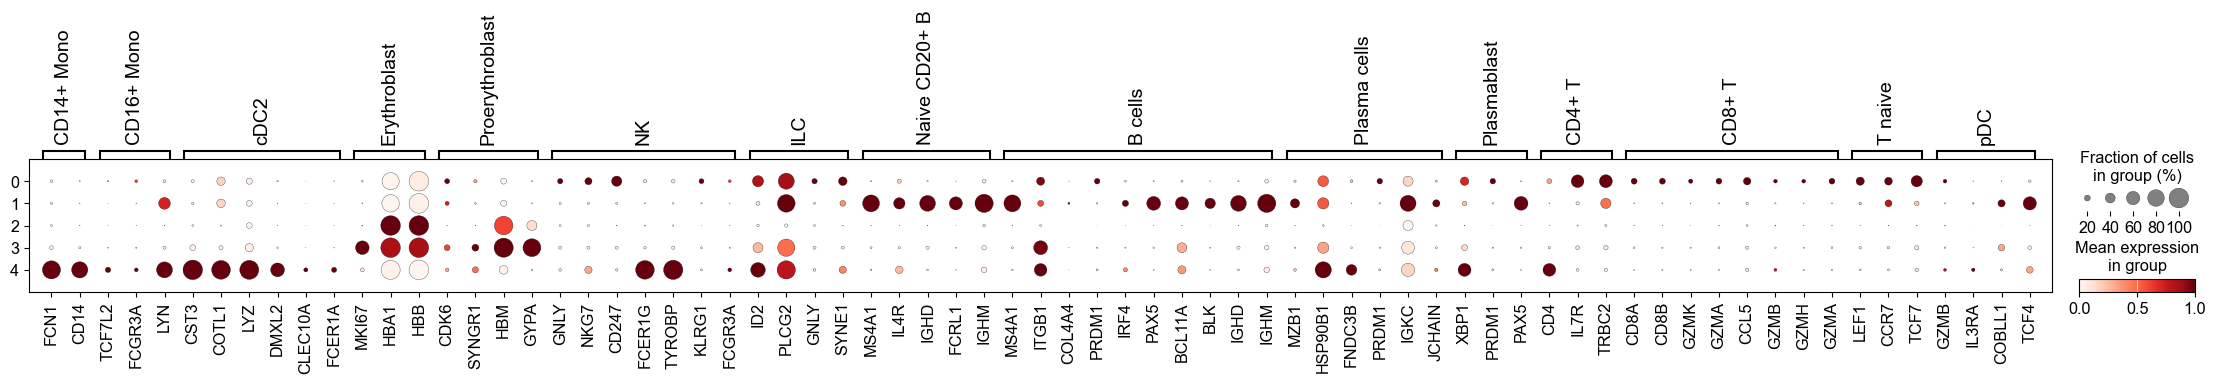

In [73]:
# plot a dotplot showing which marker genes correspond to which cell types
sc.pl.dotplot(adata, marker_genes, groupby="leiden_res_0.02", standard_scale="var")


Even at this low resolution of 0.02, we can see that these marker genes can identify differences in broad classes of cell types. Let's label those.

In [74]:
# here we label the leiden 0.02 resolution clusters 0-4 by broad-scale cell types, 
#   given that these clusters look different for our broad classes in the dotplot above
adata.obs["cell_type_lvl1"] = adata.obs["leiden_res_0.02"].map(
    {
        "0": "Lymphocytes",
        "1": "Monocytes",
        "2": "Erythroid",
        "3": "B Cells",
    }
)

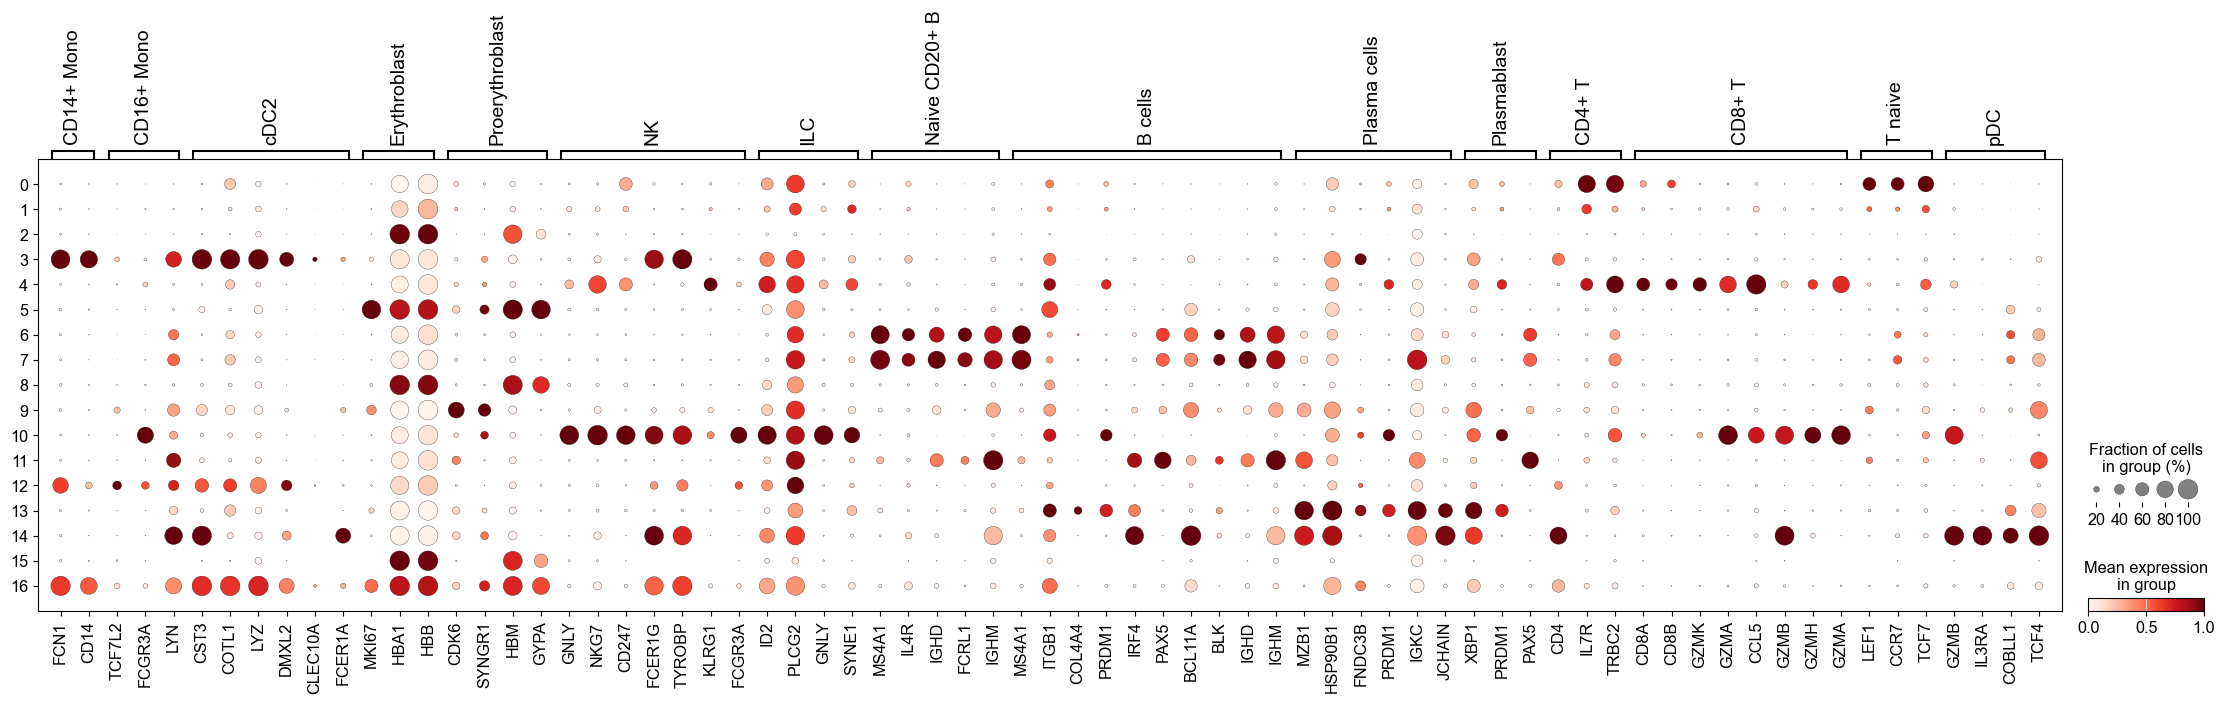

In [75]:
# now let's look at the medium resolution
sc.pl.dotplot(adata, marker_genes, groupby="leiden_res_0.50", standard_scale="var")

From this, we could label the finer-grained cell types in accordance with the Leiden clusters as well, similarly to how we labeled the coarse-grained cell types.

Another approach is to first identify marker genes of each cluster as those differentially expressed in that cluster, and then see if we can link those to any known biology, such as cell types and/or states. This is typically done using simple statistical tests, such as Wilcoxon or t-tests, for each cluster vs the rest.

In [76]:
# Obtain cluster-specific differentially-expressed genes
sc.tl.rank_genes_groups(adata, groupby="leiden_res_0.50", method="wilcoxon")

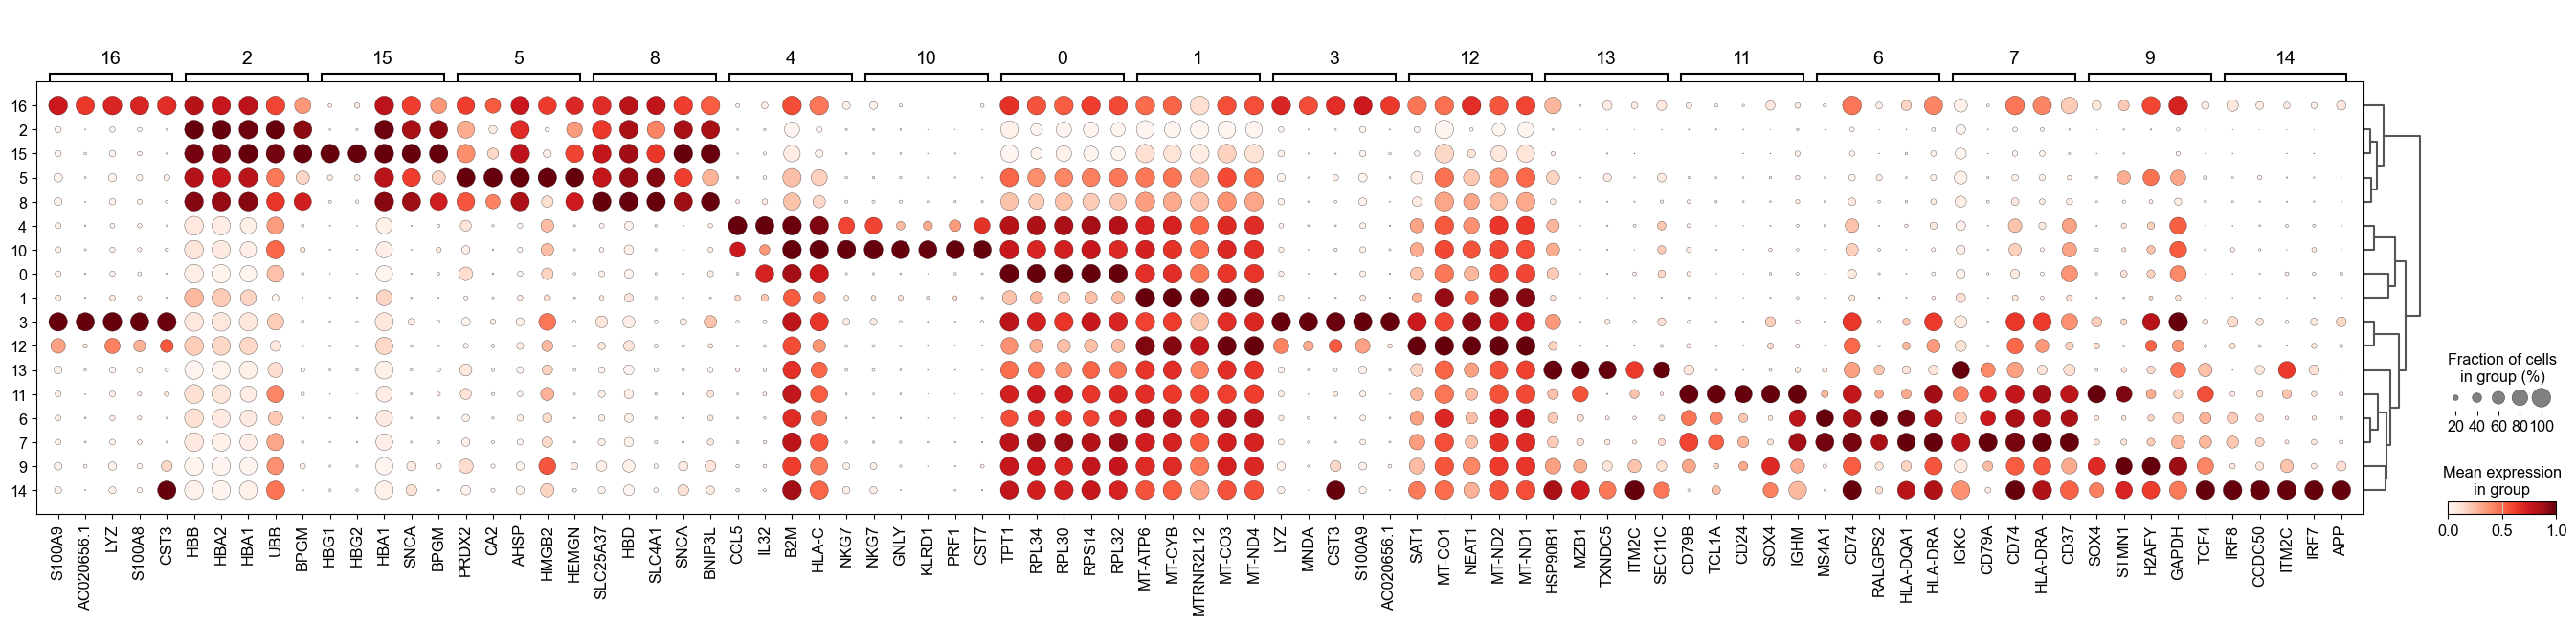

In [77]:
# now let's visualize the top 5 differentially-expressed genes on a dotplot
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="leiden_res_0.50", standard_scale="var", n_genes=5
)

We can then use these genes to figure out what cell types we're looking at. For example, cluster 7 is expressing NKG7 and GNLY, suggesting that they are NK cells.

To create our own plots, or use a more automated approach, the differentially-expressed genes can be extracted in a convenient format with `scanpy.get.rank_genes_groups_df()`

In [78]:
sc.get.rank_genes_groups_df(adata, group="7").head(5)

,names,scores,logfoldchanges,pvals,pvals_adj
0,IGKC,50.084213,6.081635,0.0,0.0
1,CD79A,47.651367,5.096346,0.0,0.0
2,CD74,47.176563,4.392303,0.0,0.0
3,HLA-DRA,46.984623,4.798029,0.0,0.0
4,CD37,46.953163,3.427691,0.0,0.0


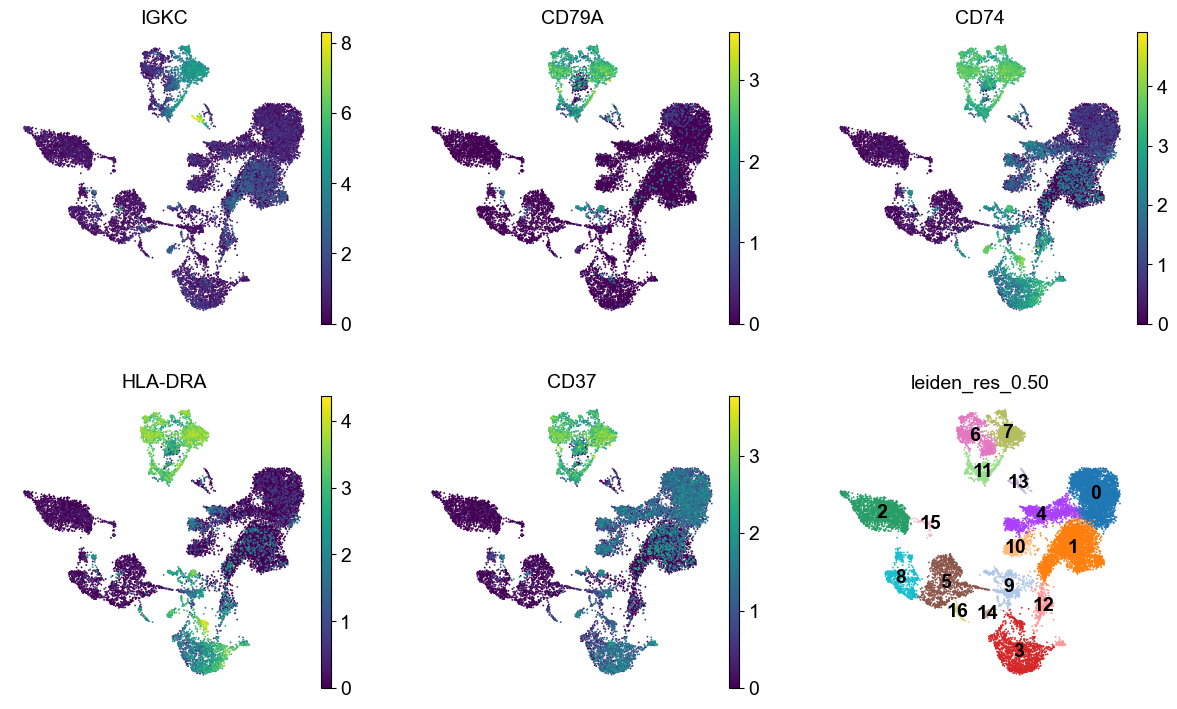

In [79]:
# visualize top 5 differentially-expressed genes for group 7 on UMAP
dc_cluster_genes = sc.get.rank_genes_groups_df(adata, group="7").head(5)["names"]
sc.pl.umap(
    adata,
    color=[*dc_cluster_genes, "leiden_res_0.50"],
    legend_loc="on data",
    frameon=False,
    ncols=3,
)

P-values above are often extremely low because the statistical test being performed considers each cell as an independent sample. For a more conservative approach you can consider "pseudo-bulking" your data by sample, e.g. using `sc.get.aggregate(adata, by=["sample", "cell_type"], func="sum", layer="counts")`, and using a more powerful differential expression tool like `pydeseq2`.